# Query Project Report

By _Guangyu (Gary) Pei_

## Introduction

[Bay Area Bike Share Trips Data](https://cloud.google.com/bigquery/public-data/bay-bike-share) are used for analysis in this project. There are total `983648` bike trips over the period from 2013-08-29 to 2016-08-31. The goal of the project is trying to come up with deals that lead to increasing ridership by offering them through the mobile app. Currently, Ford GoBike company has three options: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours and an annual membership.

Note that in the data set, we have

  - Subscriber = annual or 30-day member;
  - Customer = 24-hour or 3-day member.

My objectives of this project is to answer the following questions:

  - What are the 5 most popular trips that are considered "commuter trips"?
  - What are the recommendations for deals to offer based on the findings from the data?

In the following two sections, I will address these two questions accordingly.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

## Top 5 most popular commuter trips

Commuter trips are regular trips made by commuters who go to work in the morning and come home in the afternoon. The morning commute hours are usually from 7:00am to 9:00am and afternoon commute hours are from 4:00pm to 6:00pm. In this section, I first find the total trip frequencies among departure and arrival stations. Then, I look for regularity of bike trips over hours of day and subscriber type to refine filters to select bike trips that can be more likely categorized as commuter trips.

The following query returns total number of trips for all starting station and ending station pairs in descending order. The results are stored in data frame `station_pairs` and top 5 popular station pairs are shown.

In [2]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT
     start_station_id,
     start_station_name,
     end_station_id,
     end_station_name,
     COUNT(trip_id) AS trips_between_stas
   FROM
     `bigquery-public-data.san_francisco.bikeshare_trips`
   GROUP BY
     start_station_id,
     start_station_name,
     end_station_id,
     end_station_name
   ORDER BY
     trips_between_stas DESC' > result.csv

Waiting on bqjob_r69830eff13eae4b1_00000163e585cde6_1 ... (0s) Current status: DONE   

In [3]:
station_pairs = pd.read_csv('result.csv')
print(station_pairs['trips_between_stas'].describe())
station_pairs.head(5)

count     100.000000
mean     3470.290000
std      1564.985037
min      1858.000000
25%      2341.750000
50%      2916.500000
75%      4280.750000
max      9150.000000
Name: trips_between_stas, dtype: float64


,start_station_id,start_station_name,end_station_id,end_station_name,trips_between_stas
0,50,Harry Bridges Plaza (Ferry Building),60,Embarcadero at Sansome,9150
1,69,San Francisco Caltrain 2 (330 Townsend),65,Townsend at 7th,8508
2,61,2nd at Townsend,50,Harry Bridges Plaza (Ferry Building),7620
3,50,Harry Bridges Plaza (Ferry Building),61,2nd at Townsend,6888
4,60,Embarcadero at Sansome,74,Steuart at Market,6874


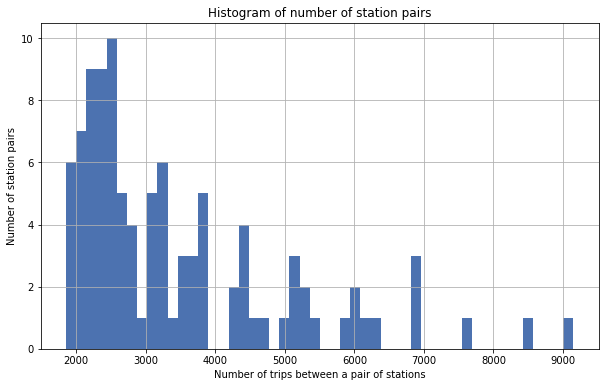

In [4]:
station_pairs.hist(column='trips_between_stas', bins=50, figsize = (10, 6))
plt.title('Histogram of number of station pairs')
plt.xlabel('Number of trips between a pair of stations')
plt.ylabel('Number of station pairs')
plt.rcParams["font.size"] = 15

__Figure 1: Distribution of station pairs by trip count between them__

These popular station pairs are located in commuting centers (such as ferry building and Caltrain station) and downtown office building areas. Also, the distribution is right skewed by popular station pairs. This indicates that these station pairs are likely commute trips since commute trips tend to repeat regularly. To further analyze, the distribution of trip frequencies over hours of a day and rider types are presented below.

In [5]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
 SELECT
   EXTRACT(HOUR FROM start_date) AS hr, subscriber_type, COUNT(trip_id) AS num_trips
 FROM
   `bigquery-public-data.san_francisco.bikeshare_trips`
 GROUP BY subscriber_type, hr
 ORDER BY
   hr, subscriber_type' > result.csv

Waiting on bqjob_r2f562bf9c922ea0_00000163e586377b_1 ... (0s) Current status: DONE   

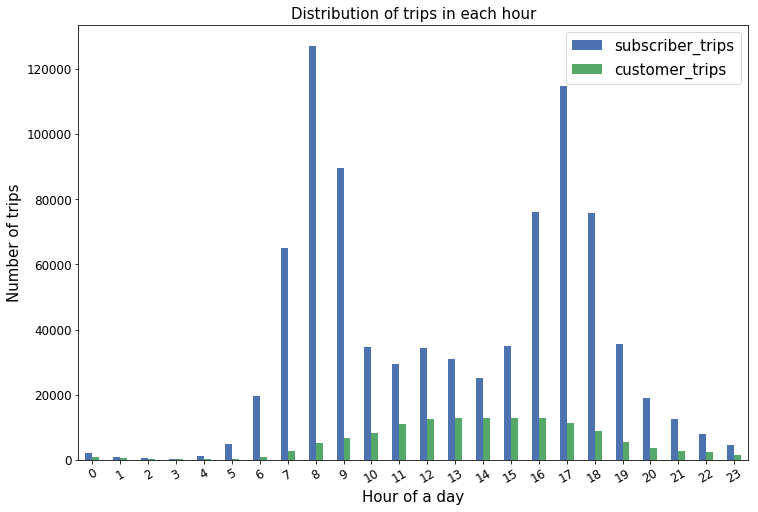

In [6]:
hourly_trips = pd.read_csv('result.csv')
df_cust = hourly_trips.loc[hourly_trips['subscriber_type'] == 'Customer'].set_index('hr')
df_cust.columns = ['customer', 'customer_trips']
df_sub = hourly_trips.loc[hourly_trips['subscriber_type'] == 'Subscriber'].set_index('hr')
df_sub.columns = ['subscriber', 'subscriber_trips']
df = df_sub.join(df_cust)
df = df[['subscriber_trips','customer_trips']]
ax = df.plot(kind='bar', figsize = (12, 8), fontsize = 12, rot = 30)
ax.set_xlabel('Hour of a day', fontsize = 15)
ax.set_ylabel('Number of trips', fontsize = 15)
ax.set_title('Distribution of trips in each hour', fontdict = {'fontsize':15})
ax.legend(fontsize = 15)

__Figure 2: Distribution of bike trip frequencies over hour of day and subscriber type__

The above figure shows that subscribers dominate the morning commute hours from 7:00 am to 9:00 am and afternoon commute hours from 4:00 pm to 6:00 pm. This makes sense since commuters are likely subscribers because they ride bikes for commuting on a regular basis. Based on this observation, the trip match conditions are modified to include commuting hours (namely 7-9 am and 4-6 pm) and subscriber type to finalize the rank for top 5 commute trips.

In [7]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT start_station_id, start_station_name, end_station_id, end_station_name, COUNT(trip_id) AS trips_between_stas
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
  (EXTRACT(HOUR FROM start_date) IN (7,8,9,16,17,18)) AND ( subscriber_type = "Subscriber")
GROUP BY
  start_station_id, start_station_name, end_station_id, end_station_name
ORDER BY
  trips_between_stas DESC' > result.csv

Waiting on bqjob_r31b7155d7641e799_00000163e6057b49_1 ... (0s) Current status: DONE   

In [8]:
final_commute_trips = pd.read_csv('result.csv')
final_commute_trips.head(5)

,start_station_id,start_station_name,end_station_id,end_station_name,trips_between_stas
0,61,2nd at Townsend,50,Harry Bridges Plaza (Ferry Building),5128
1,69,San Francisco Caltrain 2 (330 Townsend),65,Townsend at 7th,5104
2,50,Harry Bridges Plaza (Ferry Building),61,2nd at Townsend,5068
3,60,Embarcadero at Sansome,74,Steuart at Market,4772
4,51,Embarcadero at Folsom,70,San Francisco Caltrain (Townsend at 4th),4708


##### Summary

In summary, the 5 most popular trips that are considered commuter trips are given below.

|Departure Station|Arrival Station|Rank|
|:------:|:------:|:------:|
|2nd at Townsend|Harry Bridges Plaza (Ferry Building)|1|
|San Francisco Caltrain 2 (330 Townsend)|Townsend at 7th|2|
|Harry Bridges Plaza (Ferry Building)|2nd at Townsend|3|
|Embarcadero at Sansome|Steuart at Market|4|
|Embarcadero at Folsom|San Francisco Caltrain (Townsend at 4th)|5|




## Recommendations for offers

As illustrated in the Figure 2, different types of subscribers exhibit different usage patterns. The bike riders with subscriptions dominates the customer base and their bike trips primarily concentrate during commute hours. Thus, one strategy of increasing ridership is to encourage more commuters to use bikes. To further the studies, more explorations of the data set are needed. In the following, exploration data analysis is performed.

##### Trip frequencies by day of week and subscriber types

The following query and plot provide the results on trip frequencies for each day of week and subscriber types.

In [9]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT
   EXTRACT(DAYOFWEEK FROM start_date) AS day_of_wk, subscriber_type, COUNT(trip_id) AS num_trips
 FROM
   `bigquery-public-data.san_francisco.bikeshare_trips`
 GROUP BY subscriber_type, day_of_wk
 ORDER BY
   day_of_wk, subscriber_type' > result.csv

Waiting on bqjob_r41732bf99ac7b02_00000163e643ec10_1 ... (0s) Current status: DONE   

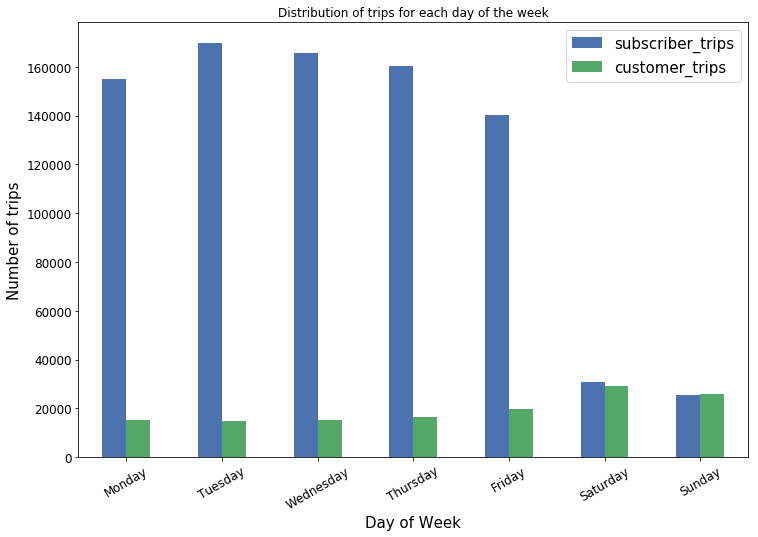

In [10]:
trips_by_wkdays = pd.read_csv('result.csv')
df_cust = trips_by_wkdays.loc[trips_by_wkdays['subscriber_type'] == 'Customer'].set_index('day_of_wk')
df_cust.columns = ['customer', 'customer_trips']
df_sub = trips_by_wkdays.loc[trips_by_wkdays['subscriber_type'] == 'Subscriber'].set_index('day_of_wk')
df_sub.columns = ['subscriber', 'subscriber_trips']
df = df_sub.join(df_cust)
df = df[['subscriber_trips','customer_trips']]
df.rename({1: 'Sunday', 2:'Monday', 3:'Tuesday', 4:'Wednesday', 5:'Thursday', 6:'Friday', 7:'Saturday'},
          axis='index',  inplace=True)
df = df.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], :]
ax = df.plot(kind='bar', figsize = (12, 8), fontsize = 12, rot = 30,
       title = 'Distribution of trips for each day of the week')
ax.set_xlabel('Day of Week', fontsize = 15)
ax.set_ylabel('Number of trips', fontsize = 15)
ax.legend(fontsize = 15)

__Figure 3: Distribution of trip frequencies over day of week and subscriber types__

Figure 3 shows that weekday trips dominate the distribution. The customers with 24-hour or 3-day member have similar number of trips during weekends as annual or 30-day members. Clearly, the weekend trips are for leisure. It will be difficult to improve ridership during the weekends as majority of people have many other options. Thus, the deals should focus on increasing ridership during weekdays. Members with annual or 30-day subscriptions have the lion share of the bike trips. Thus, it is important to offer deals and make it easier for commuters to use bikes as part of their daily commute routine.

##### Bike duration pattern

In the following, I will investigate how ling bike users will usually use bikes for.

In [11]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT
   t.subscriber_type as subscriber_type, t.timerange AS durations,
   COUNT(t.trip_id) AS number_of_trips
 FROM (
   SELECT
     subscriber_type, trip_id,
     CASE
       WHEN duration_sec <= 1800 THEN "0 - 30 mins"
       WHEN duration_sec > 1800 AND duration_sec < 3600 THEN "30 mins - 1 hr"
       WHEN duration_sec >= 3600 AND duration_sec < 7200 THEN "1 hr - 2 hrs"
       WHEN duration_sec >= 7200 AND duration_sec < 10800 THEN "2 - 3 hrs"
       WHEN duration_sec >= 10800 AND duration_sec < 14400 THEN "3 - 4 hrs"
       WHEN duration_sec >= 14400 AND duration_sec < 18000 THEN "4 - 5 hrs"
       WHEN duration_sec >= 18000 AND duration_sec < 21600 THEN "5 - 6 hrs"
       WHEN duration_sec >= 21600 AND duration_sec < 25200 THEN "6 - 7 hrs"
       WHEN duration_sec >= 25200 AND duration_sec < 28800 THEN "7 - 8 hrs"
       WHEN duration_sec >= 28800 AND duration_sec < 32400 THEN "8 - 9 hrs"
       WHEN duration_sec >= 32400 AND duration_sec < 36000 THEN "9 - 10 hrs"
       ELSE "10 + hrs"
     END AS timerange
   FROM
     `bigquery-public-data.san_francisco.bikeshare_trips`) t
 GROUP BY
   durations, subscriber_type
 ORDER BY
   number_of_trips DESC' > result.csv

Waiting on bqjob_r54569912637d7a8f_00000163e6444bf5_1 ... (0s) Current status: DONE   

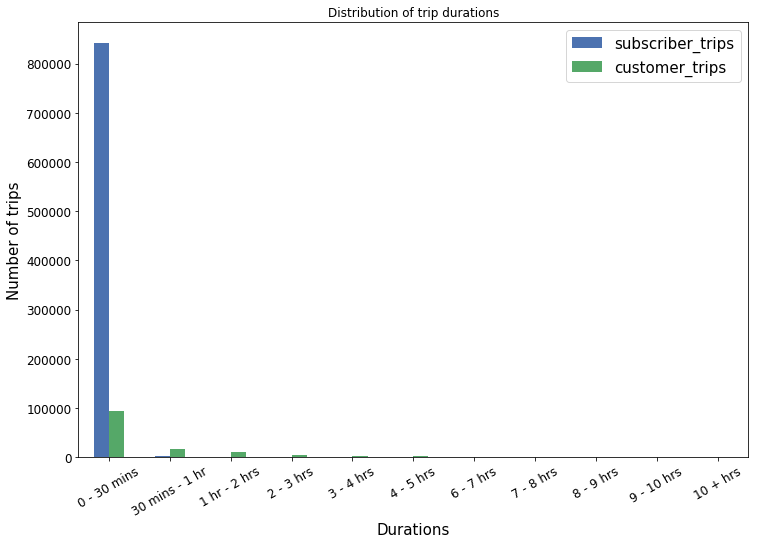

In [12]:
trip_durations = pd.read_csv('result.csv')
df_cust = trip_durations.loc[trip_durations['subscriber_type'] == 'Customer'].set_index('durations')
df_cust.columns = ['customer', 'customer_trips']
df_sub = trip_durations.loc[trip_durations['subscriber_type'] == 'Subscriber'].set_index('durations')
df_sub.columns = ['subscriber', 'subscriber_trips']
df = df_sub.join(df_cust)
df = df[['subscriber_trips','customer_trips']]
df = df.loc[['0 - 30 mins', '30 mins - 1 hr', '1 hr - 2 hrs', '2 - 3 hrs',
             '3 - 4 hrs', '4 - 5 hrs', '6 - 7 hrs', '7 - 8 hrs', '8 - 9 hrs', '9 - 10 hrs', '10 + hrs'], :]

ax = df.plot(kind='bar', figsize = (12, 8), fontsize = 12, rot = 30,
       title = 'Distribution of trip durations')
ax.set_xlabel('Durations', fontsize = 15)
ax.set_ylabel('Number of trips', fontsize = 15)
ax.legend(fontsize = 15)

__Figure 4:Trip distributions by durations__

Clearly, most bike trips are under 30 minutes. This is true for both Subscriber (annual or 30-day member) and
Customer (24-hour or 3-day member). Since the number of trips ranges several orders of magnitudes, the same distribute is plotted with $\log$ for the y-axis below.

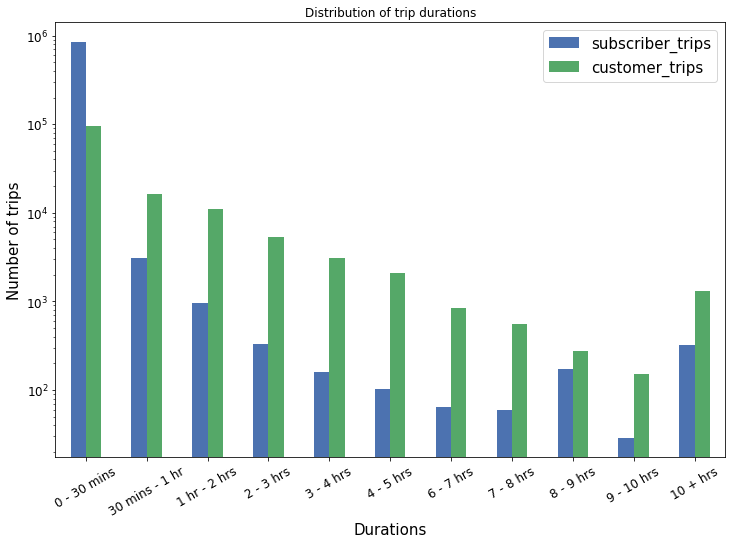

In [13]:
ax = df.plot(kind='bar', figsize = (12, 8), fontsize = 12, rot = 30, logy = True, title = 'Distribution of trip durations')
ax.set_xlabel('Durations', fontsize = 15)
ax.set_ylabel('Number of trips', fontsize = 15)
ax.legend(fontsize = 15)

__Figure 5: Trip distributions by durations with log scale__

Figure 5 shows that 24-hour or 3-day members have higher number trips above 30 minutes. This indicates that these members are likely visitors and temporary bike riders. A day pass that allows unlimited 30-minute rides may not be friendly to these. Thus, increase the length of each rides for day pass may attract more users. However, since commuters is our main customer base, we do not want to reduce number of available bikes for them. Thus, only weekends we should provide such offers.

##### Ridership trend

In this following, the ridership trend is visualized for the two year period.

In [14]:
%%bash
bq query --use_legacy_sql=FALSE --format=csv '
SELECT
   EXTRACT(YEAR FROM start_date) AS year, EXTRACT(MONTH FROM start_date) AS month, subscriber_type, COUNT(trip_id) AS num_trips
 FROM
   `bigquery-public-data.san_francisco.bikeshare_trips`
 GROUP BY subscriber_type, year, month
 ORDER BY
   year, month, subscriber_type' > result.csv

Waiting on bqjob_r4b7d335615d8f035_00000163e6bda69d_1 ... (0s) Current status: DONE   

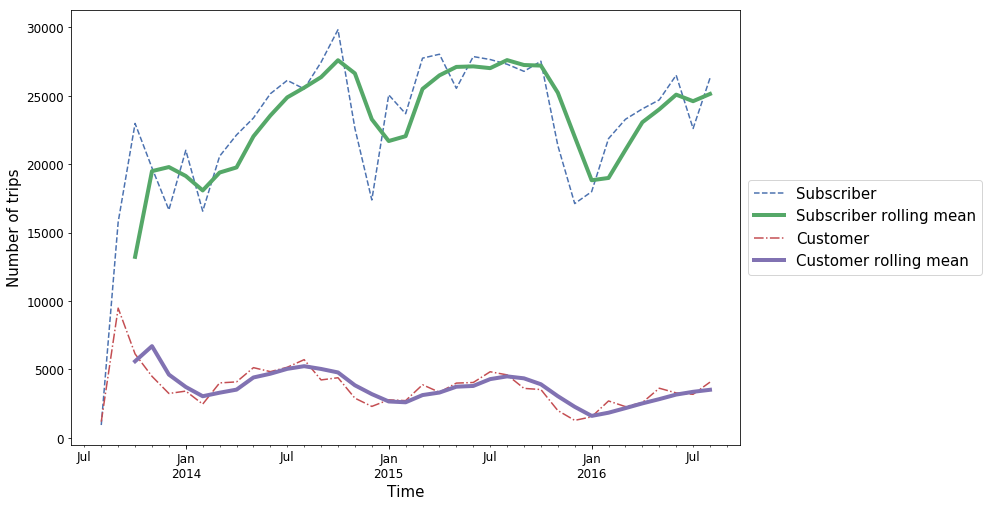

In [15]:
trips_by_month = pd.read_csv('result.csv')
import warnings
warnings.filterwarnings('ignore')

df_cust = trips_by_month.loc[trips_by_month['subscriber_type'] == 'Customer']
df_cust['day'] = 1
df_cust['date'] = pd.to_datetime(df_cust[['year','month','day']])
df_cust = df_cust.set_index('date')[['subscriber_type','num_trips']]
df_cust.columns = ['customer', 'customer_trips']

df_sub = trips_by_month.loc[trips_by_month['subscriber_type'] == 'Subscriber']
df_sub['day'] = 1
df_sub['date'] = pd.to_datetime(df_sub[['year','month','day']])
df_sub = df_sub.set_index('date')[['subscriber_type','num_trips']]
df_sub.columns = ['subscriber', 'subscriber_trips']

df = df_sub.join(df_cust)
df['subscriber_trips'].plot(linestyle = '--',  figsize = (12, 8), fontsize = 12)
ax = df['subscriber_trips'].rolling(window=3, center=False).mean().plot(linewidth=4)
df['customer_trips'].plot(linestyle = '-.',  figsize = (12, 8))
ax = df['customer_trips'].rolling(window=3, center=False).mean().plot(linewidth=4)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Number of trips', fontsize = 15)
ax.legend(['Subscriber','Subscriber rolling mean', 'Customer', 'Customer rolling mean'],
          fontsize = 15, loc='center left', bbox_to_anchor=(1,0.5))


__Figure 6: Monthly trend of trip frequencies__

Figure 6 shows the ridership monthly trend. It is clear that people ride bikes less during late fall and winter seasons and summer is the peak season because of nice weather conditions. Thus, deals in winter seasons could help to motivate riders.


##### Summary

To summarize the early observations, commuters dominate the overall bike usage and commuters are likely subscribers. Thus, more convenient bike stations near central business district and public transition center are likely to draw more users. The bike usage during weekends is low. Therefore, longer unlimited bike ride periods can be offered to visitors since they tend to have higher frequencies than subscribers for durations more than 30 minutes. Also, the commuter bike usage is concentrated during the morning and afternoon commute hours (7-9 am and 4-6 pm). Thus, more capacity should be available during evening hours and middle of the day to target other type of users. Finally, the bike ridership has a seasonal pattern. Offering good deals during the winter seasons can potentially help to increase the ridership.